In [1]:
import torch
import os
import sys
import json
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm



sys.path.append(os.path.abspath(os.path.join('..', '..')))

import src.functions.aggregation_functions as agg_funcs
from src.visualization.visualize_distributions import visualize_hist

In [2]:
PATH_PLOTS = os.path.abspath(os.path.join('..', '..', 'reports', 'plots'))

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# 1. Preparación de las pruebas

In [21]:
groupings = {
    'max': lambda x, dim=-1: torch.max(x, dim=dim)[0],
    'avg': torch.mean,
    'grouping_product': agg_funcs.product_grouping,
    'grouping_geometric': agg_funcs.geometric_grouping,
    'grouping_ob': agg_funcs.ob_grouping,
    'grouping_u': agg_funcs.u_grouping,
}

In [22]:
num_samples = 100000
num_values = 4

torch.manual_seed(0)

# NOTE: Since we want to compute the gradients for sample and it has been sampled from a 
# uniform distribution, we need to detach it from the computation graph and "readd" it again.
# Explanation: torch.rand() creates a tensor which is not a leaf tensor (it has a prior grad_fn).
samples = torch.rand([num_samples, num_values], device=device)
samples.requires_grad_(True)

tensor([[0.3990, 0.5167, 0.0249, 0.9401],
        [0.9459, 0.7967, 0.4150, 0.8203],
        [0.2290, 0.9096, 0.1183, 0.0752],
        ...,
        [0.0137, 0.3642, 0.1360, 0.4490],
        [0.3252, 0.1310, 0.2362, 0.9526],
        [0.1679, 0.3324, 0.0727, 0.2620]], device='cuda:0', requires_grad=True)

torch.Size([100000, 4])


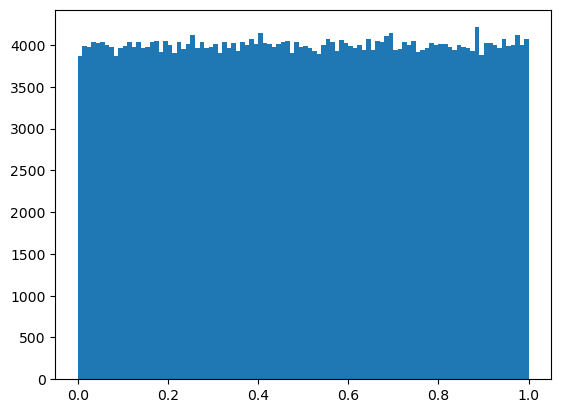

In [23]:
print(samples.shape)
visualize_hist(samples)

# 2. Simulación de poolings

In [24]:
# from tqdm import tqdm

forwards_file_name = os.path.join(PATH_PLOTS, 'forwards_poolings.json')
backwards_file_name = os.path.join(PATH_PLOTS, 'backwards_poolings.json')

if os.path.exists(forwards_file_name) and os.path.exists(backwards_file_name):
    forward_groupings_list = json.load(open(forwards_file_name, 'r'))
    forward_groupings_np = {}
    forward_groupings = {}
    for item in forward_groupings_list.items():
        name, results = item
        forward_groupings_np[name] = np.array(results)
        forward_groupings[name] = torch.from_numpy(forward_groupings_np[name])
    backward_groupings_list = json.load(open(backwards_file_name, 'r'))
    backward_groupings_np = {}
    backward_groupings = {}
    for item in backward_groupings_list.items():
        name, results = item
        backward_groupings_np[name] = np.array(results)
        backward_groupings[name] = torch.from_numpy(backward_groupings_np[name])
else:
    forward_groupings = {}
    backward_groupings = {}
    gradients = []
    for item in groupings.items():
        samples.grad = None
        name, func = item
        results = func(samples, dim=1)
        for i in tqdm(range(len(results)), unit='tests'):
            results[i].backward(retain_graph=True)
        backward_groupings[name] = samples.grad
        forward_groupings[name] = results
    

100%|██████████| 100000/100000 [01:16<00:00, 1312.19tests/s]


Save the result dictionaries to avoid having to recompute gradients:

In [25]:
backward_groupings_np = {}
backward_groupings_list = {}
for item in backward_groupings.items():
    name, results = item
    backward_groupings_np[name] = results.cpu().detach().numpy()
    backward_groupings_list[name] = backward_groupings_np[name].tolist()    
    
forward_groupings_np = {}
forward_groupings_list = {}

for item in forward_groupings.items():
    name, results = item
    forward_groupings_np[name] = results.cpu().detach().numpy()
    forward_groupings_list[name] = forward_groupings_np[name].tolist()

In [26]:
forwards_file_name = os.path.join(PATH_PLOTS, 'forwards_poolings.json')
backwards_file_name = os.path.join(PATH_PLOTS, 'backwards_poolings.json')
json.dump(forward_groupings_list, open(forwards_file_name, 'w'))
json.dump(backward_groupings_list, open(backwards_file_name, 'w'))

# 3. Resultados

 ### Activaciones

In [ ]:
num_rows = int(np.ceil(len(forward_groupings_np) / 2))
fig, axs = plt.subplots(num_rows, 2)
fig.suptitle('Activations after pooling functions')
for i, item in enumerate(forward_groupings_np.items()):
    name, results = item
    plt.subplot(num_rows, 2, i+1)
    plt.hist(results, bins=100)
    plt.title(name)
fig.tight_layout()

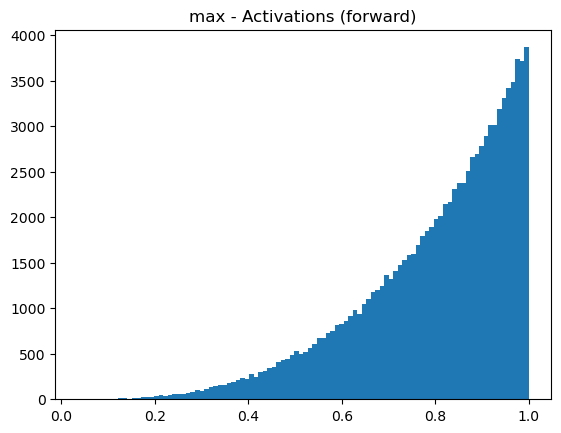

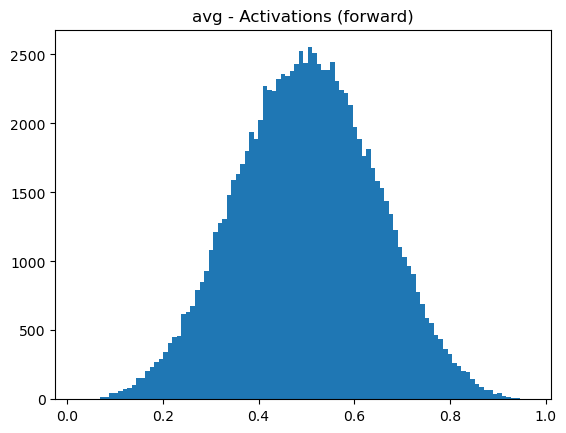

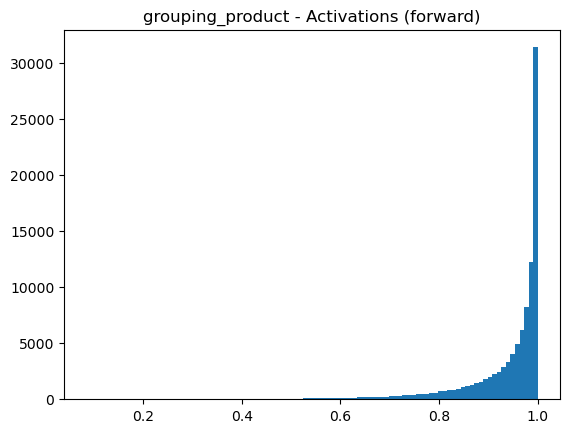

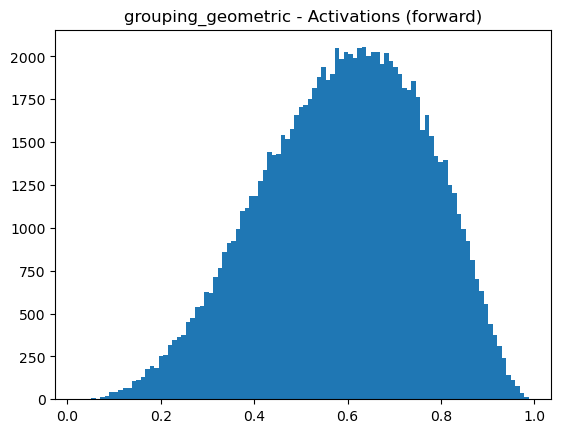

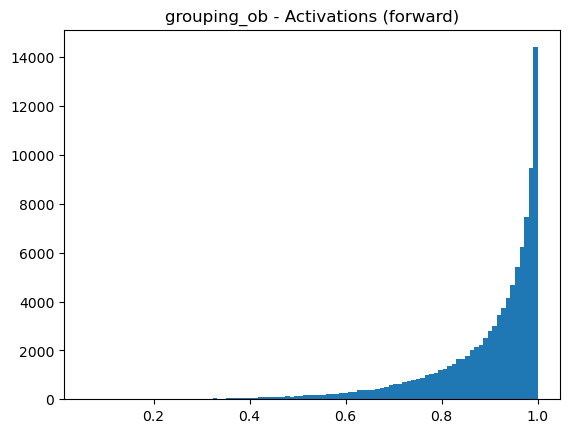

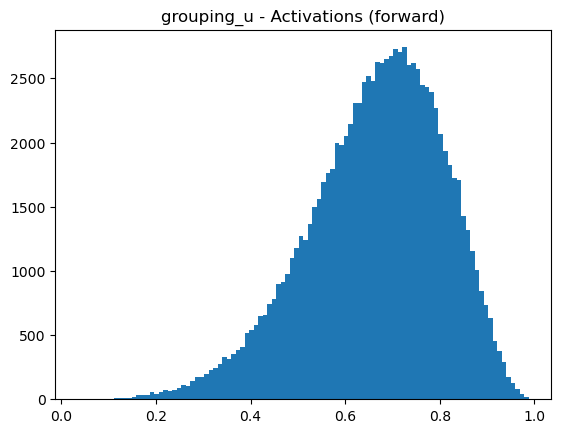

In [28]:
for item in forward_groupings.items():
    name, results = item
    visualize_hist(results, title='{} - Activations (forward)'.format(name))

### Gradientes

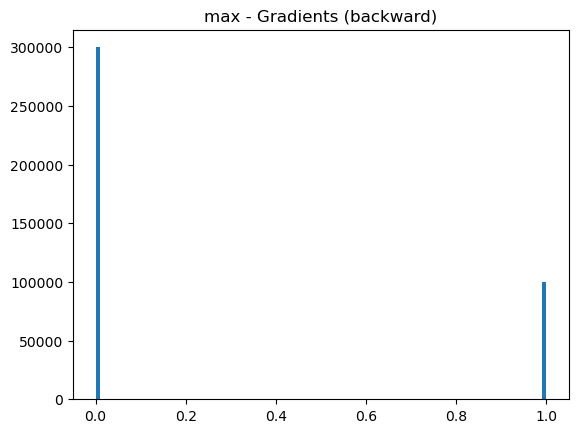

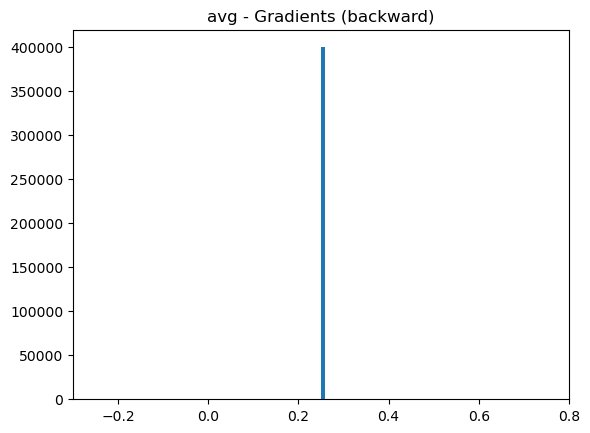

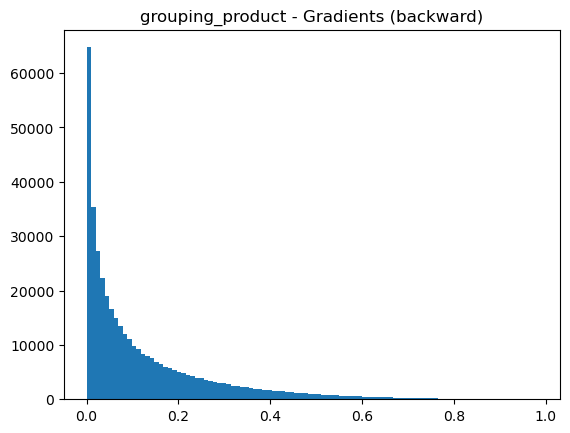

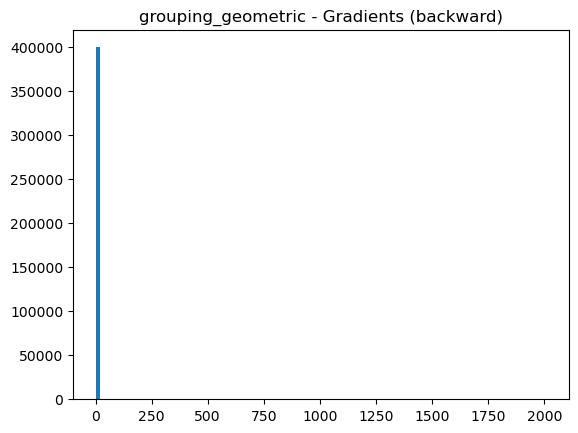

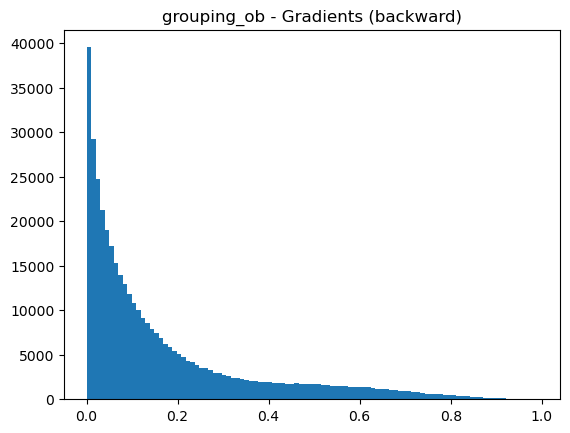

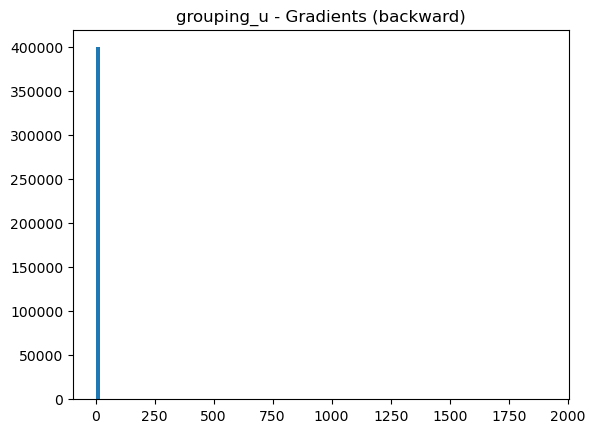

In [29]:
for item in backward_groupings.items():
    name, results = item
    visualize_hist(results, title='{} - Gradients (backward)'.format(name))

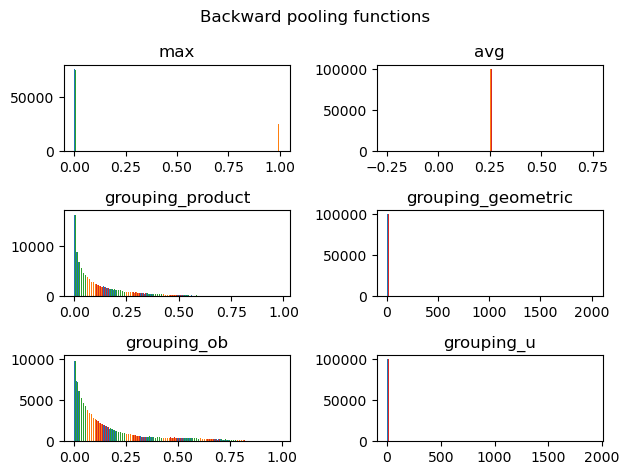

In [53]:
num_rows = int(np.ceil(len(backward_groupings_np) / 2))
fig, axs = plt.subplots(num_rows, 2)
fig.suptitle('Backward pooling functions')
for i, item in enumerate(backward_groupings_np.items()):
    name, results = item
    plt.subplot(num_rows, 2, i+1)
    plt.hist(results, bins=100)
    plt.title(name)
fig.tight_layout()

### Gradientes filtrados ($x < q_{0.99}$)

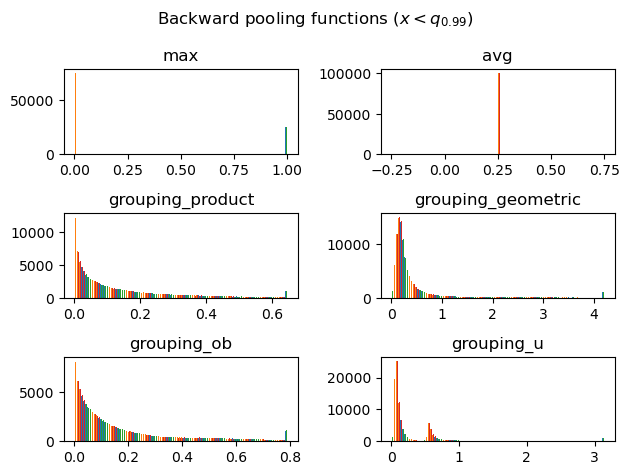

In [58]:
num_rows = int(np.ceil(len(backward_groupings_np) / 2))
fig, axs = plt.subplots(num_rows, 2)
fig.suptitle('Backward pooling functions ($x < q_{0.99}$)')
for i, item in enumerate(backward_groupings_np.items()):
    name, results = item
    plt.subplot(num_rows, 2, i+1)
    if name.startswith('grouping'):
        results = np.where(results < np.quantile(results, 0.99), results, np.quantile(results, 0.99)) 
    plt.hist(results, bins=100)
    plt.title(name)
fig.tight_layout()

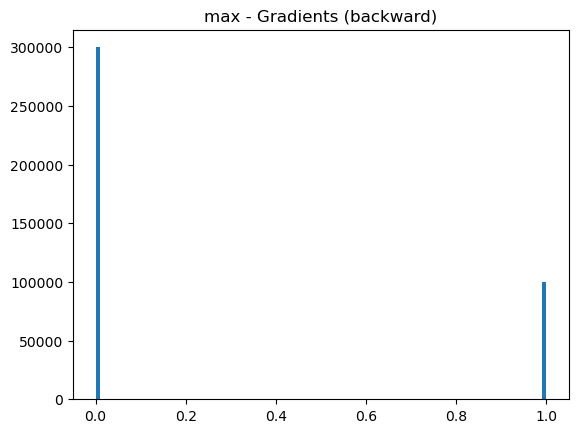

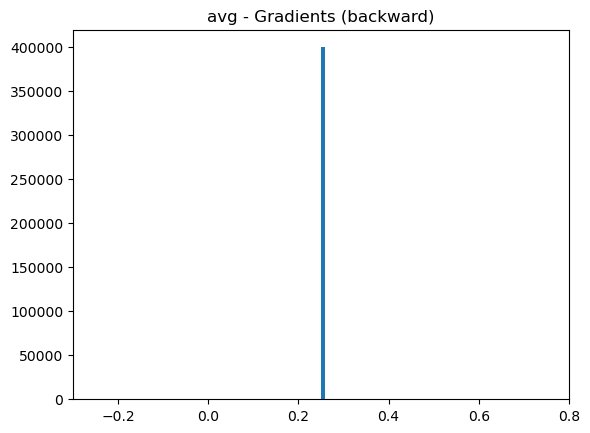

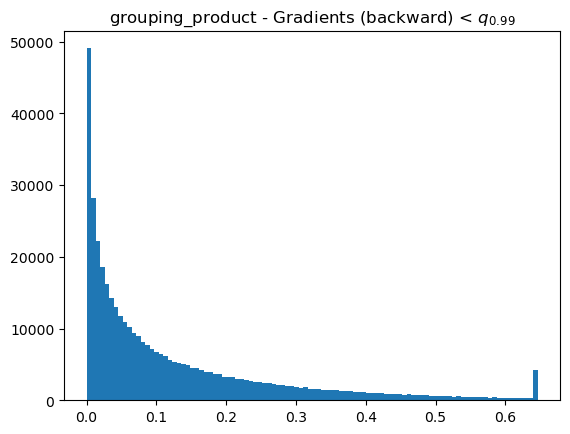

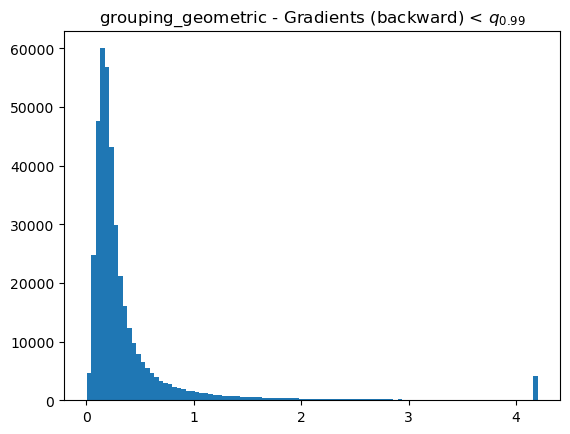

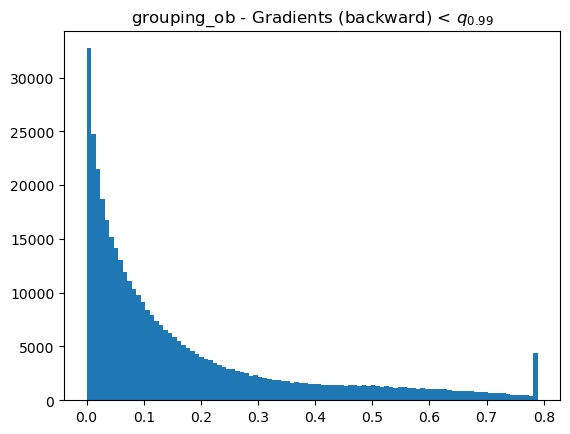

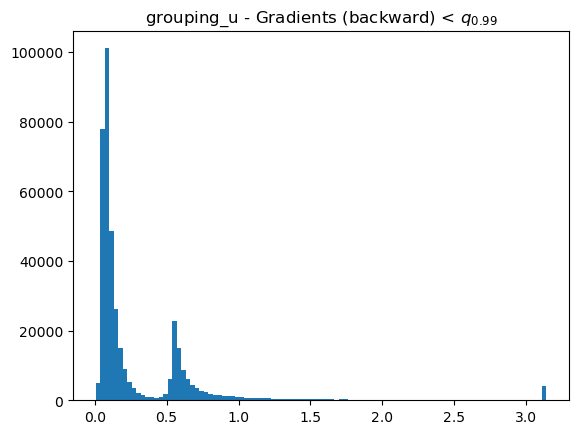

In [45]:
for item in backward_groupings.items():
    name, results = item
    # Filter results (remove values above quantile 99):
    if name.startswith('grouping'):
        results = torch.where(results < torch.quantile(results, 0.99), results, torch.quantile(results, 0.99)) 
        visualize_hist(results, title=name + r' - Gradients (backward) < $q_{0.99}$')
    else:
        visualize_hist(results, title='{} - Gradients (backward)'.format(name))

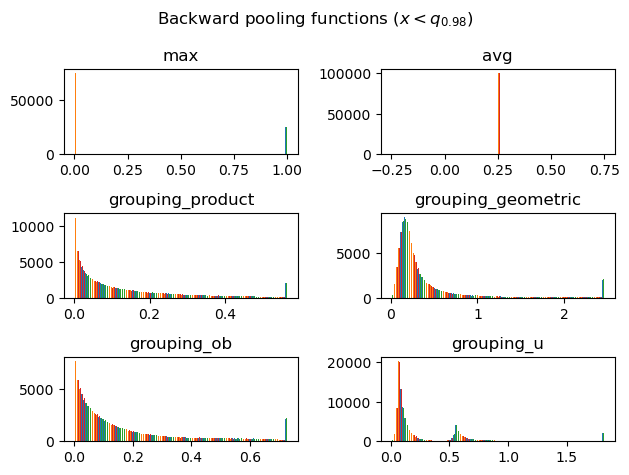

In [59]:
num_rows = int(np.ceil(len(backward_groupings_np) / 2))
fig, axs = plt.subplots(num_rows, 2)
fig.suptitle('Backward pooling functions ($x < q_{0.98}$)')
for i, item in enumerate(backward_groupings_np.items()):
    name, results = item
    plt.subplot(num_rows, 2, i+1)
    if name.startswith('grouping'):
        results = np.where(results < np.quantile(results, 0.98), results, np.quantile(results, 0.98)) 
    plt.hist(results, bins=100)
    plt.title(name)
fig.tight_layout()

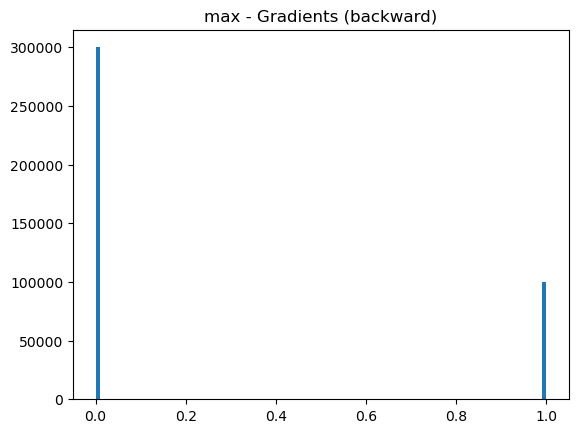

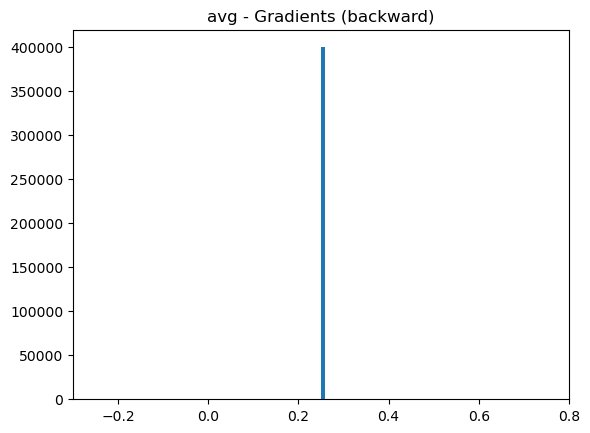

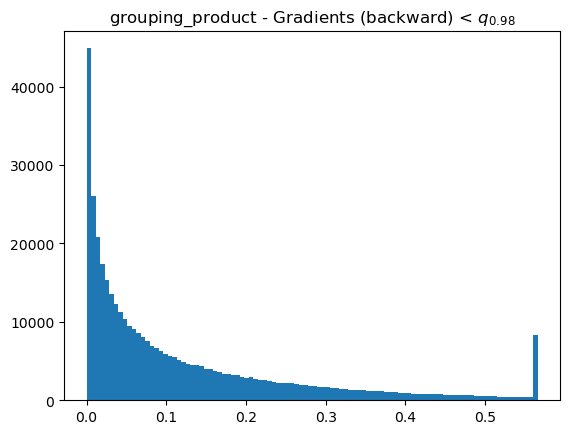

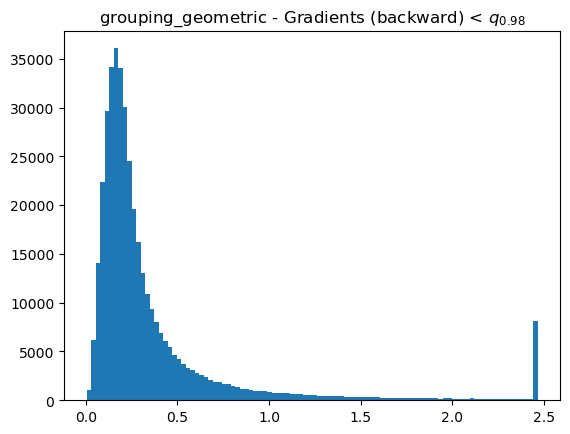

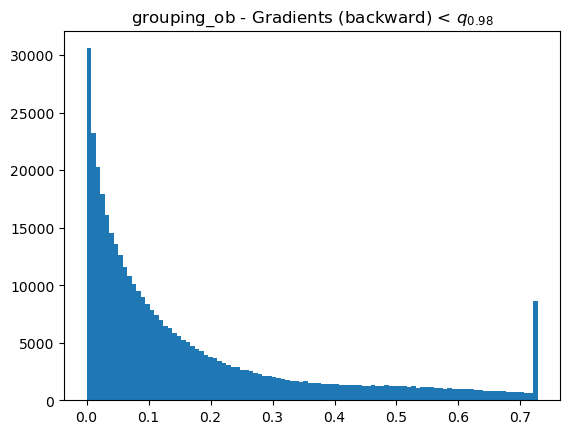

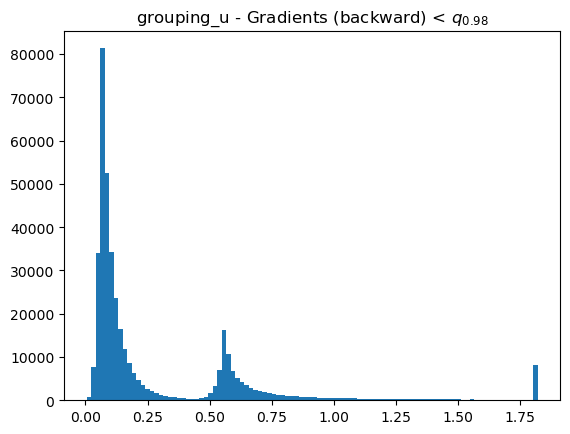

In [44]:
for item in backward_groupings.items():
    name, results = item
    # Filter results (remove values above quantile 99):
    if name.startswith('grouping'):
        results = torch.where(results < torch.quantile(results, 0.98), results, torch.quantile(results, 0.98)) 
        # results = results[results < torch.quantile(results, 0.98)]
        visualize_hist(results, title=name + r' - Gradients (backward) < $q_{0.98}$')
    else:
        visualize_hist(results, title='{} - Gradients (backward)'.format(name))

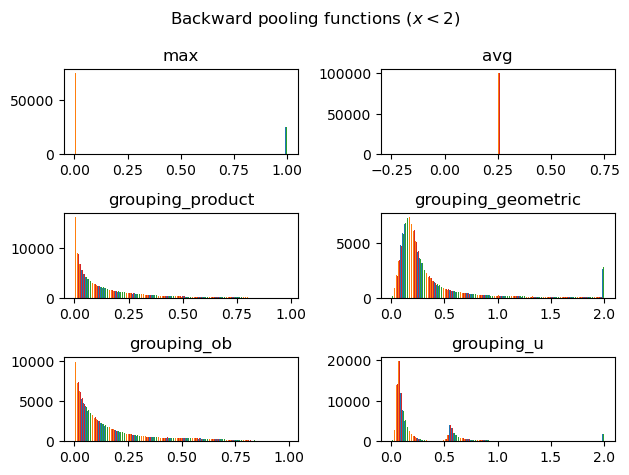

In [60]:
num_rows = int(np.ceil(len(backward_groupings_np) / 2))
fig, axs = plt.subplots(num_rows, 2)
fig.suptitle('Backward pooling functions ($x < 2$)')
for i, item in enumerate(backward_groupings_np.items()):
    name, results = item
    plt.subplot(num_rows, 2, i+1)
    if name.startswith('grouping'):
        results = np.where(results < 2, results, 2) 
    plt.hist(results, bins=100)
    plt.title(name)
fig.tight_layout()

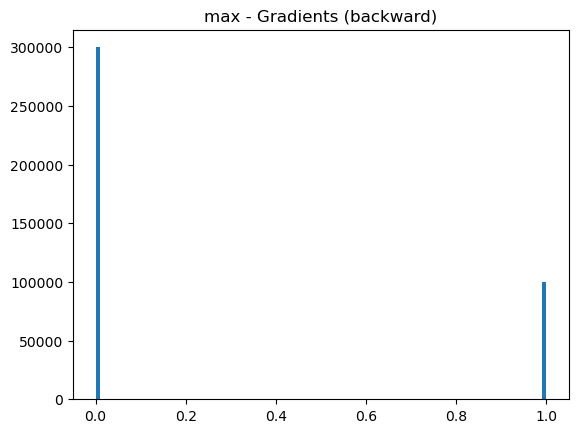

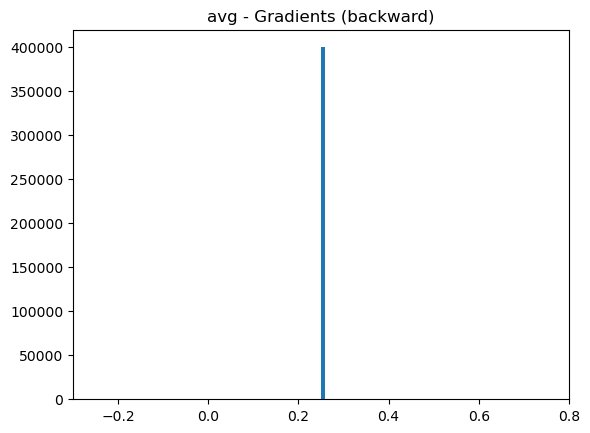

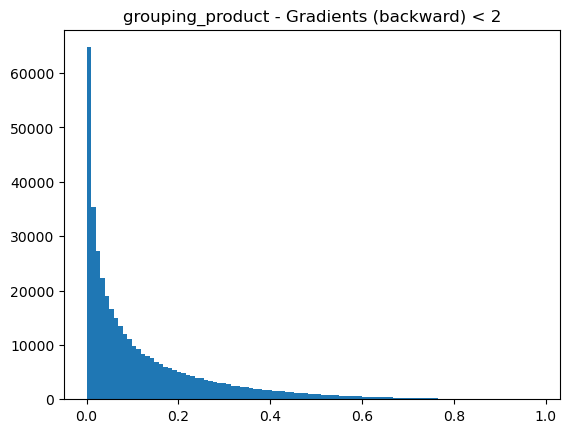

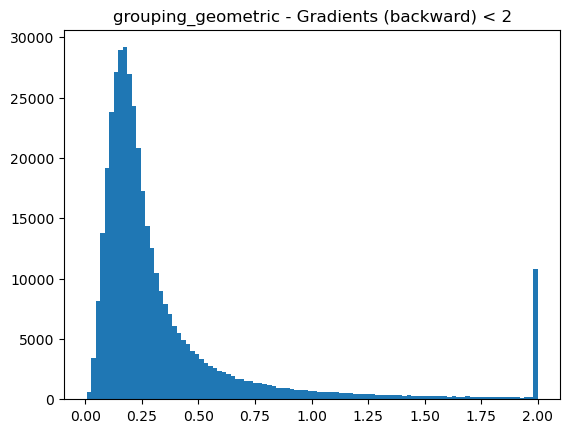

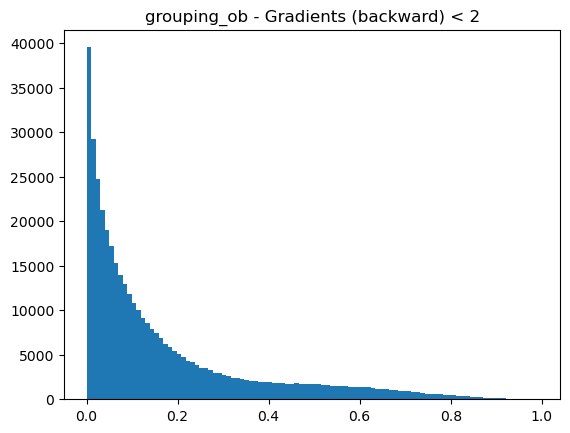

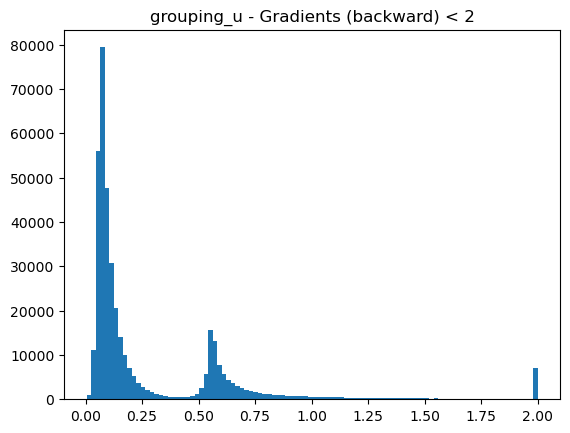

In [41]:
for item in backward_groupings.items():
    name, results = item
    # Filter results (remove values above quantile 99):
    if name.startswith('grouping'):
        results = torch.where(results < 2, results, torch.tensor(2.0, device=device)) 
        visualize_hist(results, title=name + r' - Gradients (backward) < 2')
    else:
        visualize_hist(results, title='{} - Gradients (backward)'.format(name))

# Análisis de los gradientes del grouping 'u'

In [52]:
import numpy as np

backward_groupings_np = {}
for item in backward_groupings.items():
    name, results = item
    backward_groupings_np[name] = results.cpu().numpy()

# backward_groupings_np['u'].index(backward_groupings_np['u'].max())
print(backward_groupings_np['u'].max())
print(backward_groupings_np['u'] == backward_groupings_np['u'].max())
indices = np.where(backward_groupings_np['u'] == backward_groupings_np['u'].max())


print(backward_groupings_np['u'][indices])
print(backward_groupings_np['u'])
# index = backward_groupings['u'].index(backward_groupings['u'].max())
# (backward_groupings['u'] == backward_groupings['u'].max())

1232.2335
[[False False False False]
 [False False False False]
 [False False False False]
 ...
 [False False False False]
 [False False False False]
 [False False False False]]
[1232.2335]
[[ 0.7768026   0.09762736  0.05925275  0.10347149]
 [ 1.2068378   0.1341711   0.07472881  0.05777703]
 [ 0.11430977  0.13043001  0.5496464   0.0731319 ]
 ...
 [12.920392    0.04530207  0.04116591  0.0448555 ]
 [ 0.08135308  0.5783709   0.07656749  0.10765763]
 [ 0.97496486  0.06799721  0.06454019  0.10003836]]


In [67]:
forward_groupings_np = {}
for item in forward_groupings.items():
    name, results = item
    forward_groupings_np[name] = results.cpu().detach().numpy()
samples_np = samples
# samples_np = samples.cpu().detach().numpy()    

print('Values of samples: {}'.format(samples_np[indices[0]]))
print('Values of activations: {}'.format(forward_groupings_np['u'][indices[0]]))
print('Values of gradients: {}'.format(backward_groupings_np['u'][indices]))

Values of samples: [[0.37115794 0.83195037 0.9999957  0.47355855]]
Values of activations: [0.978371]
Values of gradients: [1232.2335]


In [71]:
prueba_u = torch.tensor([0, 0, 1, 0], dtype=torch.float, requires_grad=True, device=device)
print(prueba_u)
result_u = agg_funcs.u_grouping(prueba_u)
result_u.backward()
print(prueba_u.grad)

tensor([0., 0., 1., 0.], device='cuda:0', requires_grad=True)
tensor([      0.,       0., 7855931.,       0.], device='cuda:0')


In [72]:
prueba_u = torch.tensor([0.5, 0.5, 1, 0.5], dtype=torch.float, requires_grad=True, device=device)
print(prueba_u)
result_u = agg_funcs.u_grouping(prueba_u)
result_u.backward()
print(prueba_u.grad)

tensor([0.5000, 0.5000, 1.0000, 0.5000], device='cuda:0', requires_grad=True)
tensor([     0.0000,      0.0000, 981991.3750,      0.0000], device='cuda:0')


In [73]:
prueba_geom = torch.tensor([0, 0, 1, 0], dtype=torch.float, requires_grad=True, device=device)
print(prueba_geom)
result_geom = agg_funcs.u_grouping(prueba_geom)
result_geom.backward()
print(prueba_geom.grad)

tensor([0., 0., 1., 0.], device='cuda:0', requires_grad=True)
tensor([      0.,       0., 7855931.,       0.], device='cuda:0')
